<a href="https://colab.research.google.com/github/freida20git/SubjectiveQA-Rater/blob/main/notebooks/simple_Bert_regresor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# 1. Mount Drive and import libraries
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import torch.nn as nn
from sklearn.model_selection import train_test_split

# 1. Load and preprocess data
file_path = '/content/drive/MyDrive/colab/filtered_data.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')
df = df.fillna("")



In [5]:
#drop all besides: 'answer_satisfaction'import pandas as pd
# Rename target column to "label" (required by HuggingFace)
df = df.rename(columns={"answer_satisfaction": "label"})
# Define metrics to drop (ALL metrics except answer_relevance which we just renamed to 'label')
drop_cols = [
 'question_asker_intent_understanding',
 'question_body_critical',
 'question_conversational',
 'question_expect_short_answer',
 'question_fact_seeking',
 'question_has_commonly_accepted_answer',
 'question_interestingness_others',
 'question_interestingness_self',
 'question_multi_intent',
 'question_not_really_a_question',
 'question_opinion_seeking',
 'question_type_choice',
 'question_type_compare',
 'question_type_consequence',
 'question_type_definition',
 'question_type_entity',
 'question_type_instructions',
 'question_type_procedure',
 'question_type_reason_explanation',
 'question_type_spelling',
 'question_well_written',
 'answer_helpful',
 'answer_level_of_information',
 'answer_plausible',
 'answer_relevance',
 'answer_type_instructions',
 'answer_type_procedure',
 'answer_type_reason_explanation',
 'answer_well_written'
]

# Drop ONLY columns that exist
df = df.drop(columns=[col for col in drop_cols if col in df.columns])
df = df.fillna("")

df["text"] = (
    "Title: " + df["question_title"] +
    " [SEP] Body: " + df["question_body"] +
    " [SEP] Answer: " + df["answer"]
)

# Final cleanup: drop raw text columns, keep metadata + label + text
df = df[["qa_id", "text", "category", "host", "label"]]

# Optional: verify no duplicates in column names or data
assert df.columns.duplicated().sum() == 0, "Duplicate column names!"
print("✅ Final DataFrame shape:", df.shape)
print("📄 Columns:", df.columns.tolist())
df.head()


✅ Final DataFrame shape: (6079, 5)
📄 Columns: ['qa_id', 'text', 'category', 'host', 'label']


,qa_id,text,category,host,label
0,0,Title: What am I losing when using extension t...,LIFE_ARTS,photo.stackexchange.com,0.800000
1,1,Title: What is the distinction between a city ...,CULTURE,rpg.stackexchange.com,0.666667
2,2,Title: Maximum protusion length for through-ho...,SCIENCE,electronics.stackexchange.com,0.666667
3,3,Title: Can an affidavit be used in Beit Din? [...,CULTURE,judaism.stackexchange.com,0.800000
4,5,Title: How do you make a binary image in Photo...,LIFE_ARTS,graphicdesign.stackexchange.com,0.800000


In [6]:
from datasets import Dataset
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
dataset = Dataset.from_pandas(df)

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=512)

dataset = dataset.train_test_split(test_size=0.2)
tokenized_dataset = dataset.map(tokenize, batched=True)

# # Prepare labels as one vector of 30 floats
# def format_dataset(example):
#     example["labels"] = [example[m] for m in metric_cols]
#     return example

# tokenized_dataset = tokenized_dataset.map(format_dataset)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/4863 [00:00<?, ? examples/s]

Map:   0%|          | 0/1216 [00:00<?, ? examples/s]

In [7]:
print(df.columns)


Index(['qa_id', 'text', 'category', 'host', 'label'], dtype='object')


In [8]:
import torch
import torch.nn as nn
from transformers import AutoModel

class SimpleMultiMetricBERT(nn.Module):
    def __init__(self, model_name="bert-base-uncased", num_outputs=30):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.2)
        self.regressor = nn.Linear(self.bert.config.hidden_size, num_outputs)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        preds = self.regressor(self.dropout(pooled_output))  # shape: (batch_size, 30)

        if labels is not None:
            loss_fn = nn.MSELoss()
            loss = loss_fn(preds, labels)
            return {"loss": loss, "logits": preds}
        return {"logits": preds}


In [9]:
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr

def compute_metrics(eval_pred):
    preds, labels = eval_pred

    preds = np.squeeze(np.array(preds))   # (batch_size, 1) -> (batch_size,)
    labels = np.squeeze(np.array(labels)) # כנ"ל

    metrics = {}
    metrics["mse"] = mean_squared_error(labels, preds)

    # הגנות למקרה שהמערך קבוע ולא ניתן לחשב קורלציה
    try:
        metrics["pearson"] = pearsonr(labels, preds)[0]
    except:
        metrics["pearson"] = 0.0

    try:
        metrics["spearman"] = spearmanr(labels, preds).correlation
    except:
        metrics["spearman"] = 0.0

    return metrics


In [10]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/simple_30reg_output",
    run_name="simple_30reg",
    report_to="none",
    eval_strategy="epoch",         # תיקון שם הפרמטר מ-eval_strategy
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="mse"          # רלוונטי ל-label אחת בלבד
)

# ודא שהמודל מתאים לרגרסיה עם output אחד
model = SimpleMultiMetricBERT(model_name="bert-base-uncased", num_outputs=1)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/tmp/ipython-input-3338483290.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [11]:
trainer.train()

# Evaluate
from pprint import pprint
metrics = trainer.evaluate()
print("📊 Evaluation Results:")
pprint(metrics)

# Save final model
trainer.save_model("bert-30-simple")
tokenizer.save_pretrained("bert-30-simple")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch,Training Loss,Validation Loss,Mse,Pearson,Spearman
1,0.042700,0.019509,0.019670,-0.116573,-0.106367
2,0.022700,0.016978,0.017010,-0.048088,-0.062902
3,0.019600,0.016701,0.016690,0.006735,-0.014537


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: Use

📊 Evaluation Results:
{'epoch': 3.0,
 'eval_loss': 0.019509373232722282,
 'eval_mse': 0.01966964639723301,
 'eval_pearson': -0.11657265573740005,
 'eval_runtime': 34.6215,
 'eval_samples_per_second': 35.123,
 'eval_spearman': -0.10636748796412766,
 'eval_steps_per_second': 4.39}


('bert-30-simple/tokenizer_config.json',
 'bert-30-simple/special_tokens_map.json',
 'bert-30-simple/vocab.txt',
 'bert-30-simple/added_tokens.json',
 'bert-30-simple/tokenizer.json')

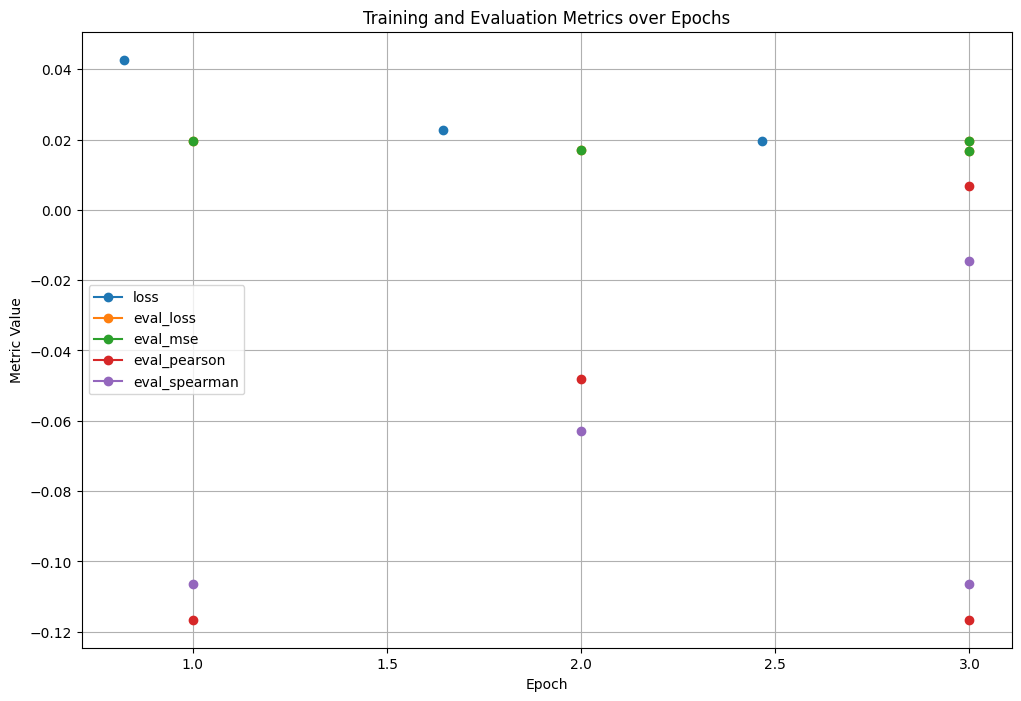

In [12]:
# 📈 Plot metrics over epochs
logs = trainer.state.log_history
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(logs)

# Filter only epochs (הסר לוגים לא רלוונטיים כמו evaluation לפני epoch 1)
df = df[df['epoch'].notna()]

metrics_to_plot = ['loss', 'eval_loss', 'eval_mse', 'eval_pearson', 'eval_spearman']

plt.figure(figsize=(12, 8))
for metric in metrics_to_plot:
    if metric in df.columns:
        plt.plot(df['epoch'], df[metric], marker='o', label=metric)

plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("Training and Evaluation Metrics over Epochs")
plt.legend()
plt.grid(True)
plt.show()

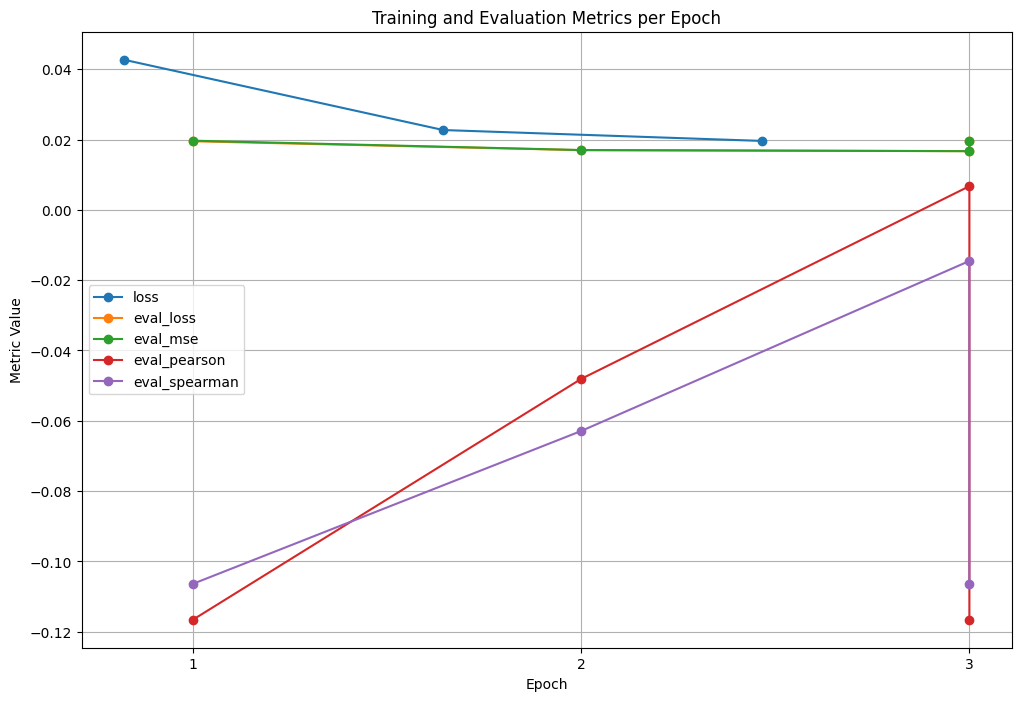

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# המרת הלוג לפורמט טבלה
logs = trainer.state.log_history
df = pd.DataFrame(logs)

# סינון שורות עם ערך אפוק
df = df[df['epoch'].notna()]
df['epoch'] = df['epoch'].astype(float)

# רשימת המטריקות שתרצה לצייר
metrics_to_plot = ['loss', 'eval_loss', 'eval_mse', 'eval_pearson', 'eval_spearman']

# ציור
plt.figure(figsize=(12, 8))
for metric in metrics_to_plot:
    if metric in df.columns:
        sub_df = df[['epoch', metric]].dropna()  # סינון NaN כדי לא לשבור את הקו
        plt.plot(sub_df['epoch'], sub_df[metric], marker='o', label=metric)

plt.xticks([1, 2, 3])  # רק האפוקים השלמים
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("Training and Evaluation Metrics per Epoch")
plt.legend()
plt.grid(True)
plt.show()
